# Previsão de Preços de Imóveis

Neste projeto iremos analisar os dados obtidos por uma API e criar um modelo de aprendizado de máquina capaz de prever o valor do imóvel.

Como modelo deste projeto teremos o **CRISP-DM** como base:

1. **Definir o problema de negócio**
2. **Coleta de dados e uma visão geral sobre eles.**
3. **Explorar os dados (análise exploraória).**
4. **Limpeza e pré-processamento dos dados.**
5. **Separar os dados em treino e teste.**
6. **Modelagem de dados, comparação, seleção e aprimoramento do modelo.**
7. **Concluir e interpretar o modelo.**
8. **Geração de insights.**

# 1.Problema de Negócio

- Fui contratado por uma imobiliária para gerir, analisar e insights sobre os dados da empresa. Foi-me atribuido a tarefa de entender a correlação do preço do imóvel com cada uma das features que a emprese obtinha no seu site, e em seguida prever o valor de um imóvel. Para esta tarefa irei criar um modelo de **Regressão** para nos dar este valor.

- **1.1 Qual o contexto?**
    - Para a imobiliária é importante ter precisão ao precificar um imóvel, desta forma os lucros seriam maximizados e os prejuísos minimizados.

- **1.2 Qual o objetivo do projeto?**
    - Criar um modelo que preveja o preço do imóvel com uma precisão alta.

# 2. Entendimento dos Dados

**EDA**

**Importando bibliotecas**

In [108]:
# manipula pastas e arquivos
import os

# vizualização e maniupulação de dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.regressor import PredictionError

# filtra avisos
import warnings
warnings.filterwarnings('ignore')

# pré-processamento de dados
from sklearn.preprocessing import FunctionTransformer

# modelagem
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# configuração e paleta de cores
cor_paleta = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']
sns.set_palette(sns.color_palette(cor_paleta))
sns.color_palette(cor_paleta)

[(0.00784313725490196, 0.18823529411764706, 0.2784313725490196),
 (0.9098039215686274, 0.36470588235294116, 0.01568627450980392),
 (0.0, 0.4666666666666667, 0.7137254901960784),
 (1.0, 0.5098039215686274, 0.0),
 (0.0, 0.5882352941176471, 0.7803921568627451),
 (1.0, 0.611764705882353, 0.2)]

In [2]:
data = pd.read_json('..//data//raw/imoveis.json')
data.head()

,ident,listing
0,"{'customerID': '775564-BOJSMVON', 'source': 'W...","{'types': {'unit': 'Outros', 'usage': 'Residen..."
1,"{'customerID': '660895-AUENKNYY', 'source': 'W...","{'types': {'unit': 'Apartamento', 'usage': 'Re..."
2,"{'customerID': '751522-JESYFEQL', 'source': 'W...","{'types': {'unit': 'Outros', 'usage': 'Residen..."
3,"{'customerID': '714052-GAAEWYKS', 'source': 'W...","{'types': {'unit': 'Outros', 'usage': 'Comerci..."
4,"{'customerID': '568886-ZIBFOMCC', 'source': 'W...","{'types': {'unit': 'Apartamento', 'usage': 'Re..."


Os dados obtivos pela API estão em formato JSON, precisamos reformula-los a DataFrame para termos uma visualização melhor.

In [3]:
data.ident[0]

{'customerID': '775564-BOJSMVON', 'source': 'Website'}

In [4]:
data.listing[0]

{'types': {'unit': 'Outros', 'usage': 'Residencial'},
 'address': {'city': 'Rio de Janeiro',
  'location': {'lon': -43.413557, 'lat': -22.909429},
  'zone': 'Zona Oeste',
  'neighborhood': 'Taquara'},
 'prices': {'price': '45000', 'tax': {'iptu': '0', 'condo': '150'}},
 'features': {'bedrooms': 0,
  'bathrooms': 0,
  'suites': 0,
  'parkingSpaces': 1,
  'usableAreas': '62',
  'totalAreas': '62',
  'floors': 0,
  'unitsOnTheFloor': 0,
  'unitFloor': 0}}

**Transformando estrutura JSON**

In [5]:
data_list1 = pd.json_normalize(data.ident)
data_list1.head()

,customerID,source
0,775564-BOJSMVON,Website
1,660895-AUENKNYY,Website
2,751522-JESYFEQL,Website
3,714052-GAAEWYKS,Website
4,568886-ZIBFOMCC,Website


In [6]:
data_list2 = pd.json_normalize(data.listing, sep='_')
data_list2.head()

,types_unit,types_usage,address_city,address_location_lon,address_location_lat,address_zone,address_neighborhood,prices_price,prices_tax_iptu,prices_tax_condo,features_bedrooms,features_bathrooms,features_suites,features_parkingSpaces,features_usableAreas,features_totalAreas,features_floors,features_unitsOnTheFloor,features_unitFloor
0,Outros,Residencial,Rio de Janeiro,-43.413557,-22.909429,Zona Oeste,Taquara,45000,0,150,0,0,0,1,62,62,0,0,0
1,Apartamento,Residencial,Rio de Janeiro,-43.509141,-22.869698,Zona Oeste,Santíssimo,45000,0,120,2,1,0,1,44,0,0,0,0
2,Outros,Residencial,Rio de Janeiro,-43.646786,-22.986927,Zona Oeste,Pedra de Guaratiba,50000,0,100,0,0,0,0,132,132,0,0,0
3,Outros,Comercial,Rio de Janeiro,-43.330818,-22.881977,Zona Norte,Cascadura,45000,346,468,0,1,0,0,32,32,0,0,3
4,Apartamento,Residencial,Rio de Janeiro,-43.480742,-23.027653,Zona Oeste,Recreio dos Bandeirantes,50000,120,400,3,2,1,1,60,0,3,4,2


**Juntando DataFrames**

In [7]:
data_imoveis = pd.concat([data_list1, data_list2],axis = 1)
data_imoveis.head()

,customerID,source,types_unit,types_usage,address_city,address_location_lon,address_location_lat,address_zone,address_neighborhood,prices_price,...,prices_tax_condo,features_bedrooms,features_bathrooms,features_suites,features_parkingSpaces,features_usableAreas,features_totalAreas,features_floors,features_unitsOnTheFloor,features_unitFloor
0,775564-BOJSMVON,Website,Outros,Residencial,Rio de Janeiro,-43.413557,-22.909429,Zona Oeste,Taquara,45000,...,150,0,0,0,1,62,62,0,0,0
1,660895-AUENKNYY,Website,Apartamento,Residencial,Rio de Janeiro,-43.509141,-22.869698,Zona Oeste,Santíssimo,45000,...,120,2,1,0,1,44,0,0,0,0
2,751522-JESYFEQL,Website,Outros,Residencial,Rio de Janeiro,-43.646786,-22.986927,Zona Oeste,Pedra de Guaratiba,50000,...,100,0,0,0,0,132,132,0,0,0
3,714052-GAAEWYKS,Website,Outros,Comercial,Rio de Janeiro,-43.330818,-22.881977,Zona Norte,Cascadura,45000,...,468,0,1,0,0,32,32,0,0,3
4,568886-ZIBFOMCC,Website,Apartamento,Residencial,Rio de Janeiro,-43.480742,-23.027653,Zona Oeste,Recreio dos Bandeirantes,50000,...,400,3,2,1,1,60,0,3,4,2


**Valores únicos por coluna**

In [8]:
for coluna in data_imoveis.columns:
    print('_'*70)
    print(data_imoveis[coluna].value_counts())

______________________________________________________________________
customerID
775564-BOJSMVON    1
917809-TRNXMOHE    1
125760-XEXDELYV    1
294183-VCUBOXCU    1
465524-CFDRZTHS    1
                  ..
200525-LDRZXCVM    1
938284-QWFBFUXB    1
882696-YVZSJYMI    1
566032-WFPGBXHL    1
610503-VULDJJZZ    1
Name: count, Length: 73615, dtype: int64
______________________________________________________________________
source
Website    73615
Name: count, dtype: int64
______________________________________________________________________
types_unit
Apartamento    59106
Casa            9389
Outros          5120
Name: count, dtype: int64
______________________________________________________________________
types_usage
Residencial    69596
Comercial       4019
Name: count, dtype: int64
______________________________________________________________________
address_city
Rio de Janeiro        73607
Queimados                 3
São Gonçalo               2
Cachoeirinha              1
São Joã

- É importante destacar que possuímos dois tipos de imóveis, sendo eles comerciais e residenciais. O valor de cada tipo de imóvel  vai variar por diferentes atributos, logo o correto seria fazer uma análise por cada tipo separado.

In [9]:
# separando imóveis residenciais
filtro = (data_imoveis['types_usage'] == 'Residencial') & (data_imoveis['address_city'] == 'Rio de Janeiro')

# aplicando filtro
data_imoveis = data_imoveis[filtro]
data_imoveis.head()

,customerID,source,types_unit,types_usage,address_city,address_location_lon,address_location_lat,address_zone,address_neighborhood,prices_price,...,prices_tax_condo,features_bedrooms,features_bathrooms,features_suites,features_parkingSpaces,features_usableAreas,features_totalAreas,features_floors,features_unitsOnTheFloor,features_unitFloor
0,775564-BOJSMVON,Website,Outros,Residencial,Rio de Janeiro,-43.413557,-22.909429,Zona Oeste,Taquara,45000,...,150,0,0,0,1,62,62,0,0,0
1,660895-AUENKNYY,Website,Apartamento,Residencial,Rio de Janeiro,-43.509141,-22.869698,Zona Oeste,Santíssimo,45000,...,120,2,1,0,1,44,0,0,0,0
2,751522-JESYFEQL,Website,Outros,Residencial,Rio de Janeiro,-43.646786,-22.986927,Zona Oeste,Pedra de Guaratiba,50000,...,100,0,0,0,0,132,132,0,0,0
4,568886-ZIBFOMCC,Website,Apartamento,Residencial,Rio de Janeiro,-43.480742,-23.027653,Zona Oeste,Recreio dos Bandeirantes,50000,...,400,3,2,1,1,60,0,3,4,2
5,526755-OBLTYTEN,Website,Outros,Residencial,Rio de Janeiro,-43.571183,-22.966059,Zona Oeste,Guaratiba,50000,...,0,0,0,0,0,200,200,0,0,0


In [10]:
data_imoveis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69588 entries, 0 to 73614
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customerID                69588 non-null  object 
 1   source                    69588 non-null  object 
 2   types_unit                69588 non-null  object 
 3   types_usage               69588 non-null  object 
 4   address_city              69588 non-null  object 
 5   address_location_lon      69449 non-null  float64
 6   address_location_lat      69449 non-null  float64
 7   address_zone              69588 non-null  object 
 8   address_neighborhood      69588 non-null  object 
 9   prices_price              69588 non-null  object 
 10  prices_tax_iptu           60863 non-null  object 
 11  prices_tax_condo          63527 non-null  object 
 12  features_bedrooms         69588 non-null  int64  
 13  features_bathrooms        69588 non-null  int64  
 14  features_su

- Após utilizar a filtragem, os dados estão com os indices antigos e desordenados, precisamos ordena-los de forma correta.
- Alguns dados estão com o tipo incorreto, precisamos corrigir.
- Na coluna AdressZone, existe uma ctegoria de dados que não possui string, como se tivesse vazia.
- Também há valores nulos ao qual precisamos tratar.

In [11]:
data_imoveis.reset_index(drop=True, inplace=True)

In [12]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73615 entries, 0 to 73614
Columns: 2 entries, ident to listing
dtypes: object(2)
memory usage: 1.1+ MB


In [13]:
# corrigindo tipo de dados
data_imoveis = data_imoveis.astype({
    'prices_price' : 'float64',
    'prices_tax_iptu' : 'float64',
    'prices_tax_condo' : 'float64',
    'features_usableAreas': 'int64',
    'features_totalAreas' : 'int64'
})

data_imoveis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69588 entries, 0 to 69587
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customerID                69588 non-null  object 
 1   source                    69588 non-null  object 
 2   types_unit                69588 non-null  object 
 3   types_usage               69588 non-null  object 
 4   address_city              69588 non-null  object 
 5   address_location_lon      69449 non-null  float64
 6   address_location_lat      69449 non-null  float64
 7   address_zone              69588 non-null  object 
 8   address_neighborhood      69588 non-null  object 
 9   prices_price              69588 non-null  float64
 10  prices_tax_iptu           60863 non-null  float64
 11  prices_tax_condo          63527 non-null  float64
 12  features_bedrooms         69588 non-null  int64  
 13  features_bathrooms        69588 non-null  int64  
 14  featur

In [14]:
# substituindo valores vazios por nulo
data_imoveis['address_zone'] = data_imoveis['address_zone'].replace('', np.nan)

In [15]:
data_imoveis.address_zone.isnull().sum()

149

In [16]:
data_imoveis.isnull().sum()

customerID                     0
source                         0
types_unit                     0
types_usage                    0
address_city                   0
address_location_lon         139
address_location_lat         139
address_zone                 149
address_neighborhood           0
prices_price                   0
prices_tax_iptu             8725
prices_tax_condo            6061
features_bedrooms              0
features_bathrooms             0
features_suites                0
features_parkingSpaces         0
features_usableAreas           0
features_totalAreas            0
features_floors                0
features_unitsOnTheFloor       0
features_unitFloor             0
dtype: int64

- Para tratar os valores nulos em taxa de iptu e taxa de condomínio, utilizaremos uma média dessa taxa para cada zona que a residência pertence, depois atribuir esse valores.

In [17]:
media_iptu = data_imoveis.groupby('address_zone')['prices_tax_iptu'].mean()
media_condo = data_imoveis.groupby('address_zone')['prices_tax_condo'].mean()

print('Média de IPTU por zona:', media_iptu)
print('')
print('Média de Taxa de Condominio por zona', media_condo)

Média de IPTU por zona: address_zone
Zona Central     308.425228
Zona Norte      1152.364130
Zona Oeste      4262.597838
Zona Sul        6853.043478
Name: prices_tax_iptu, dtype: float64

Média de Taxa de Condominio por zona address_zone
Zona Central    1107.802048
Zona Norte      1392.286011
Zona Oeste      3544.125306
Zona Sul        5468.885802
Name: prices_tax_condo, dtype: float64


In [18]:
# preenche os valores nulos com a média correspondente da zona
data_imoveis['prices_tax_iptu'] = data_imoveis.apply(
    lambda row: media_iptu[row['address_zone']] if pd.notnull(row['address_zone']) and row['address_zone'] in media_iptu else row['prices_tax_iptu'],
    axis=1
)

data_imoveis['prices_tax_condo'] = data_imoveis.apply(
    lambda row: media_condo[row['address_zone']] if pd.notnull(row['address_zone']) and row['address_zone'] in media_condo else row['prices_tax_condo'],
    axis=1
)

- Desta forma conseguimos substituir todos os valores nulos de taxa pela média das taxas tomando como base a zona.
- Ainda restaram alguns valores nulos, mas chegam a somar muito pouco comparado a quantidade de dados que temos no dataset, portanto irei optar por remove-los.

In [19]:
# removendo restante dos dados nulos
data_imoveis = data_imoveis.dropna()

# removendo linhas duplicadas
data_imoveis = data_imoveis.drop_duplicates()

In [20]:
data_imoveis.head()

,customerID,source,types_unit,types_usage,address_city,address_location_lon,address_location_lat,address_zone,address_neighborhood,prices_price,...,prices_tax_condo,features_bedrooms,features_bathrooms,features_suites,features_parkingSpaces,features_usableAreas,features_totalAreas,features_floors,features_unitsOnTheFloor,features_unitFloor
0,775564-BOJSMVON,Website,Outros,Residencial,Rio de Janeiro,-43.413557,-22.909429,Zona Oeste,Taquara,45000.0,...,3544.125306,0,0,0,1,62,62,0,0,0
1,660895-AUENKNYY,Website,Apartamento,Residencial,Rio de Janeiro,-43.509141,-22.869698,Zona Oeste,Santíssimo,45000.0,...,3544.125306,2,1,0,1,44,0,0,0,0
2,751522-JESYFEQL,Website,Outros,Residencial,Rio de Janeiro,-43.646786,-22.986927,Zona Oeste,Pedra de Guaratiba,50000.0,...,3544.125306,0,0,0,0,132,132,0,0,0
3,568886-ZIBFOMCC,Website,Apartamento,Residencial,Rio de Janeiro,-43.480742,-23.027653,Zona Oeste,Recreio dos Bandeirantes,50000.0,...,3544.125306,3,2,1,1,60,0,3,4,2
4,526755-OBLTYTEN,Website,Outros,Residencial,Rio de Janeiro,-43.571183,-22.966059,Zona Oeste,Guaratiba,50000.0,...,3544.125306,0,0,0,0,200,200,0,0,0


- Sabemos que cada zona representa um conjunto de bairros do Rio de Janeiro, logo temos informações suficientes para atribuir o valor nulo da zona por um valor tomando como base os outros bairros.

In [21]:
# cria um dicionário com "filtro" para relacionar bairros e zonas nulas
dict = data_imoveis[~data_imoveis['address_zone'].isna()].drop_duplicates(subset=['address_neighborhood']).to_dict('records')
print(dict)

[{'customerID': '775564-BOJSMVON', 'source': 'Website', 'types_unit': 'Outros', 'types_usage': 'Residencial', 'address_city': 'Rio de Janeiro', 'address_location_lon': -43.413557, 'address_location_lat': -22.909429, 'address_zone': 'Zona Oeste', 'address_neighborhood': 'Taquara', 'prices_price': 45000.0, 'prices_tax_iptu': 4262.597837872313, 'prices_tax_condo': 3544.125305528913, 'features_bedrooms': 0, 'features_bathrooms': 0, 'features_suites': 0, 'features_parkingSpaces': 1, 'features_usableAreas': 62, 'features_totalAreas': 62, 'features_floors': 0, 'features_unitsOnTheFloor': 0, 'features_unitFloor': 0}, {'customerID': '660895-AUENKNYY', 'source': 'Website', 'types_unit': 'Apartamento', 'types_usage': 'Residencial', 'address_city': 'Rio de Janeiro', 'address_location_lon': -43.509141, 'address_location_lat': -22.869698, 'address_zone': 'Zona Oeste', 'address_neighborhood': 'Santíssimo', 'prices_price': 45000.0, 'prices_tax_iptu': 4262.597837872313, 'prices_tax_condo': 3544.1253055

In [22]:
# dicionário de bairros para zona
dict_zone = {dic['address_neighborhood']: dic['address_zone'] for dic in dict}
print(dict_zone)

{'Taquara': 'Zona Oeste', 'Santíssimo': 'Zona Oeste', 'Pedra de Guaratiba': 'Zona Oeste', 'Recreio dos Bandeirantes': 'Zona Oeste', 'Guaratiba': 'Zona Oeste', 'Jacarezinho': 'Zona Norte', 'Santa Cruz': 'Zona Oeste', 'Vargem Grande': 'Zona Oeste', 'Bangu': 'Zona Oeste', 'Tanque': 'Zona Oeste', 'Santo Cristo': 'Zona Central', 'Coelho Neto': 'Zona Norte', 'Bento Ribeiro': 'Zona Norte', 'Campo Grande': 'Zona Oeste', 'Oswaldo Cruz': 'Zona Norte', 'Camorim': 'Zona Oeste', 'Sepetiba': 'Zona Oeste', 'Vigário Geral': 'Zona Norte', 'Campinho': 'Zona Norte', 'Realengo': 'Zona Oeste', 'Jacarepaguá': 'Zona Oeste', 'Cidade de Deus': 'Zona Oeste', 'Honório Gurgel': 'Zona Norte', 'Centro': 'Zona Central', 'Cosmos': 'Zona Oeste', 'Tomás Coelho': 'Zona Norte', 'Cascadura': 'Zona Norte', 'Pavuna': 'Zona Norte', 'Paciência': 'Zona Oeste', 'Praça Seca': 'Zona Oeste', 'Vila Valqueire': 'Zona Oeste', 'Inhoaíba': 'Zona Oeste', 'Vicente de Carvalho': 'Zona Norte', 'Senador Vasconcelos': 'Zona Oeste', 'Turiaçu'

In [23]:
# substituindo nulos
for bairro, zona in dict_zone.items(): data_imoveis.loc[data_imoveis['address_neighborhood'] == bairro, 'address_zone'] = zona

In [24]:
data_imoveis.address_zone.isnull().sum()

0

- Nulos tratados!

In [25]:
data_imoveis.prices_tax_iptu.isnull().sum()

0

In [26]:
data_imoveis.prices_tax_condo.isnull().sum()

0

**Selecionando variáveis**

In [27]:
data_imoveis.drop(['customerID', 'source', 'types_usage', 'address_city', 'address_location_lon', 'address_location_lat',
                   'address_neighborhood'], axis=1, inplace=True)

Motivo de remoção das colunas:
- `customerID` e `source` não nos oferece inforamções relevantes para a previsão.
- Já definimos que o `type_usage` será apenas espaços residenciais.
- Das cidades que temos no dataset só buscaremos prever o Rio de Janeiro.
- Latitude e longitude poderão ser utilizadas em outra etapa do projeto.
- Escolheremos as zonas (`address_zone`) invés dos bairros. Ambos possuem informações semelhantes, e por zona possuir menos categoria ficaria mais simples o modelo aprender os padrões.

**Alterando nome das colunas e variáveis**

In [28]:
col_dict = {
    'types_unit' : 'unit', 'address_zone':'zone', 'prices_price':'price', 'prices_tax_condo':'tax_condo',
    'prices_tax_iptu': 'tax_iptu', 'features_bedrooms': 'bedrooms', 'features_bathrooms': 'bathrooms', 
    'features_suites':'suites', 'features_parkingSpaces': 'parkingSpaces', 'features_usableAreas': 'usableAreas',
    'features_totalAreas':'totalAreas', 'features_floors':'floors', 'features_unitsOnTheFloor': 'unitsOnTheFloor',
    'features_unitFloor': 'unitFloor'
}

data_imoveis = data_imoveis.rename(col_dict, axis=1)
data_imoveis.head()

,unit,zone,price,tax_iptu,tax_condo,bedrooms,bathrooms,suites,parkingSpaces,usableAreas,totalAreas,floors,unitsOnTheFloor,unitFloor
0,Outros,Zona Oeste,45000.0,4262.597838,3544.125306,0,0,0,1,62,62,0,0,0
1,Apartamento,Zona Oeste,45000.0,4262.597838,3544.125306,2,1,0,1,44,0,0,0,0
2,Outros,Zona Oeste,50000.0,4262.597838,3544.125306,0,0,0,0,132,132,0,0,0
3,Apartamento,Zona Oeste,50000.0,4262.597838,3544.125306,3,2,1,1,60,0,3,4,2
4,Outros,Zona Oeste,50000.0,4262.597838,3544.125306,0,0,0,0,200,200,0,0,0


**Correlação das variáveis**

In [29]:
data_numeric = ['price', 'tax_iptu', 'tax_condo', 'bedrooms', 'bathrooms', 'suites', 'parkingSpaces', 'usableAreas', 'totalAreas',
                'floors', 'unitsOnTheFloor', 'unitFloor']


**Heatmap**

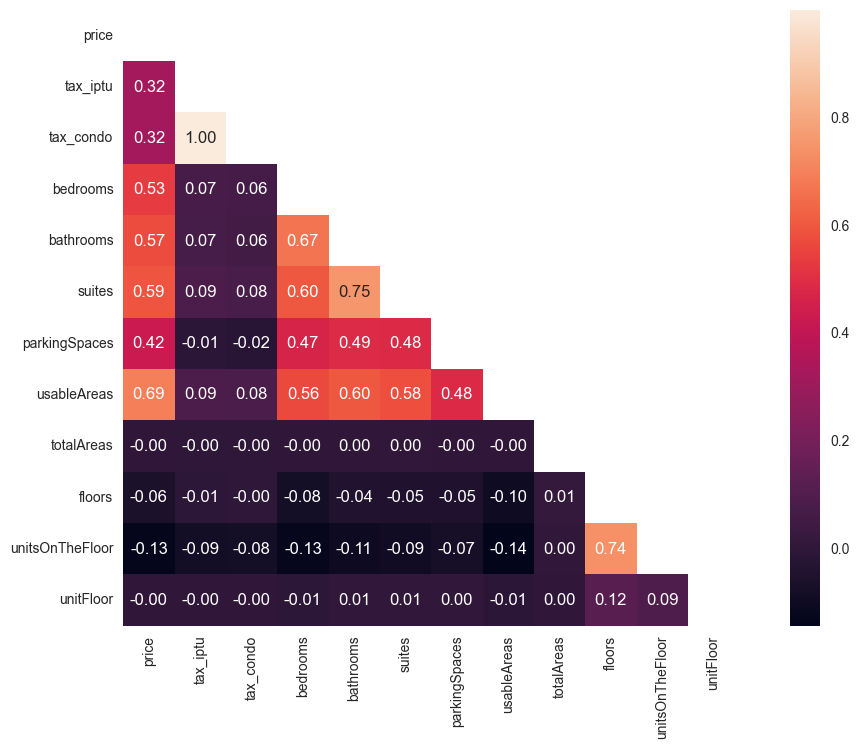

In [30]:
correlacao = data_imoveis[data_numeric].corr()

mask = np.zeros_like(correlacao)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(13,8))
    ax = sns.heatmap(correlacao, mask=mask, square=True, fmt='.2f', annot=True)

- `Suites` tem um grau alto de correlação com `bathrooms`, e `floors` com `unitsOnTheFloor`. Isso indica que existe uma multicolinearidade nos dados e que pode gerar um problema no nosso modelo.

**Distribuição dos Dados**

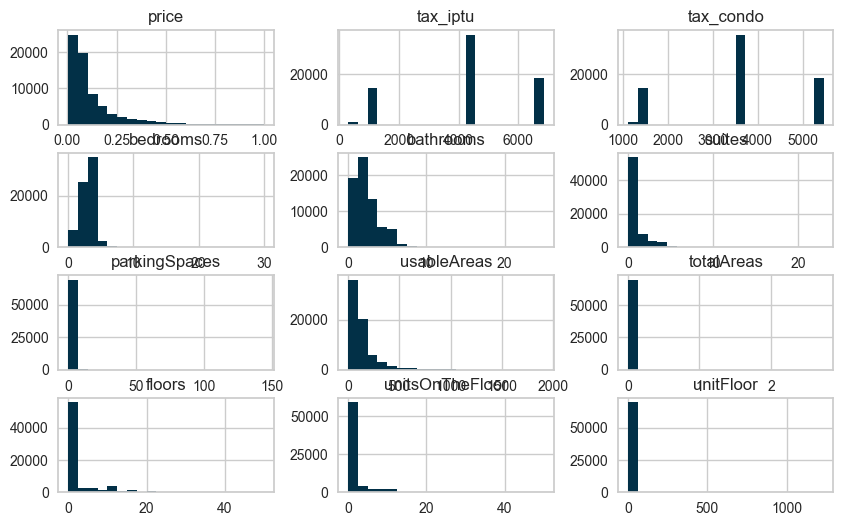

In [31]:
data_imoveis.hist(figsize=(10,6), bins=20);

- Ao observar a distrbuição dos dados, conseguimos notar uma calda longa a direita, os dados não estão distribuídos de forma simétrica (distribuição normall), e isso pode atrapalhar o desempenho do modelo previsor.

**Transformação dos Dados**

- Iremos realizar uma transofrmaçãop logarítmica das variáveis para que as distribuções se aproximem de uma normal, para que podemos utilizar o modelo de regressão linear.
- Vale lembrar de realizar a transformação inversa para obter o valor original. Isso utilizando a transformação exponencial.


In [32]:
# atribui método
transformer = FunctionTransformer(np.log1p, validate=True)

# armazena dados traansformados
data_transform = transformer.transform(data_imoveis.select_dtypes(exclude=['object']))

# concatenando colunas transformadas com colunas categóricas
cols_data_transform = data_imoveis.select_dtypes(exclude=['object']).columns

df_transformado = pd.concat([data_imoveis.select_dtypes(include=['object']), pd.DataFrame(data_transform, columns=cols_data_transform)], axis=1)
df_transformado.head()

,unit,zone,price,tax_iptu,tax_condo,bedrooms,bathrooms,suites,parkingSpaces,usableAreas,totalAreas,floors,unitsOnTheFloor,unitFloor
0,Outros,Zona Oeste,10.714440,8.357869,8.173329,0.000000,0.000000,0.000000,0.693147,4.143135,4.143135,0.000000,0.000000,0.000000
1,Apartamento,Zona Oeste,10.714440,8.357869,8.173329,1.098612,0.693147,0.000000,0.693147,3.806662,0.000000,0.000000,0.000000,0.000000
2,Outros,Zona Oeste,10.819798,8.357869,8.173329,0.000000,0.000000,0.000000,0.000000,4.890349,4.890349,0.000000,0.000000,0.000000
3,Apartamento,Zona Oeste,10.819798,8.357869,8.173329,1.386294,1.098612,0.693147,0.693147,4.110874,0.000000,1.386294,1.609438,1.098612
4,Outros,Zona Oeste,10.819798,8.357869,8.173329,0.000000,0.000000,0.000000,0.000000,5.303305,5.303305,0.000000,0.000000,0.000000


In [33]:
# removendo dados nulos
df_transformado.dropna(inplace=True)

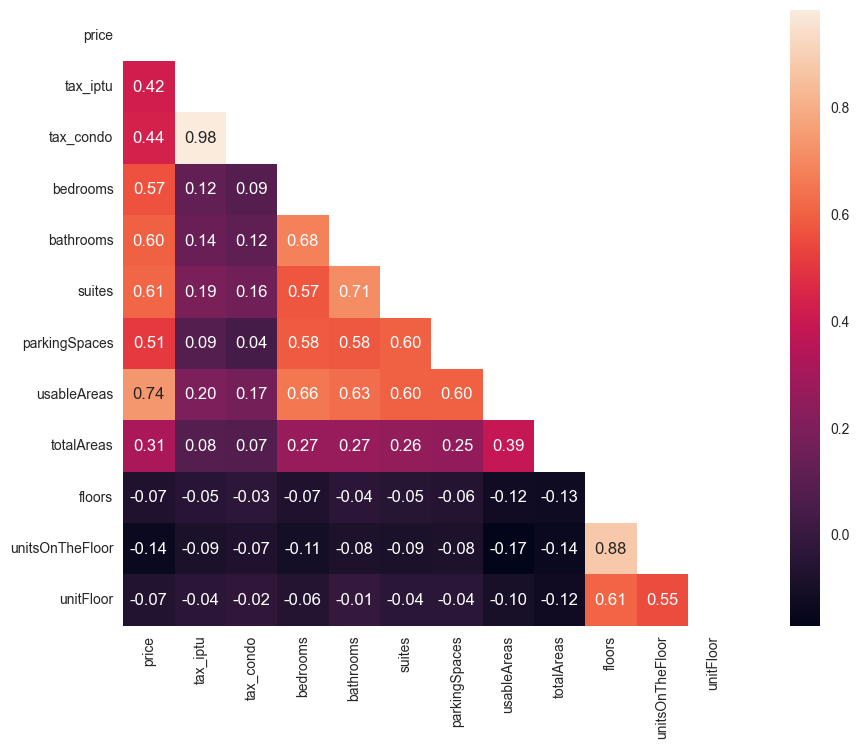

In [34]:
corr_transf = df_transformado[data_numeric].corr()

mask = np.zeros_like(corr_transf)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(13,8))
    ax = sns.heatmap(corr_transf, mask=mask, square=True, fmt='.2f', annot=True)

- A multoclinearidade foi amenizada após a transforamção logarítimica.

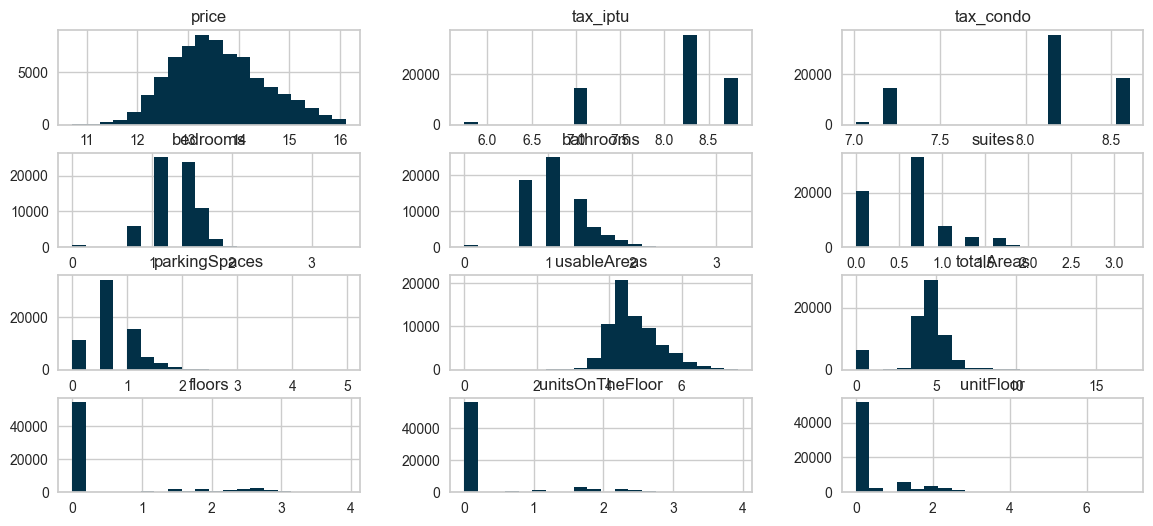

In [35]:
df_transformado.hist(figsize=(14,6), bins=20);

- A coluna price está próximo de uma normal, após a transformação logarítimica.

**Tratando variáveis categóricas**

In [36]:
data_cat = df_transformado.select_dtypes(include=['object']).columns

In [37]:
data_cat

Index(['unit', 'zone'], dtype='object')

- Uma forma de tratar essas variáveis é aplicar o método dummies, que vai transformar a presença de informação em 1 e a ausencia em 0, atribuindo-as a novas colunas.

In [38]:
df_dummies = pd.get_dummies(df_transformado[data_cat]).astype(int)
df_dummies.head()

,unit_Apartamento,unit_Casa,unit_Outros,zone_Zona Central,zone_Zona Norte,zone_Zona Oeste,zone_Zona Sul
0,0,0,1,0,0,1,0
1,1,0,0,0,0,1,0
2,0,0,1,0,0,1,0
3,1,0,0,0,0,1,0
4,0,0,1,0,0,1,0


In [39]:
# concatenando os dataframes
data_final = pd.concat([df_transformado.drop(data_cat, axis=1), df_dummies], axis=1)
data_final.head(15)

,price,tax_iptu,tax_condo,bedrooms,bathrooms,suites,parkingSpaces,usableAreas,totalAreas,floors,unitsOnTheFloor,unitFloor,unit_Apartamento,unit_Casa,unit_Outros,zone_Zona Central,zone_Zona Norte,zone_Zona Oeste,zone_Zona Sul
0,10.714440,8.357869,8.173329,0.000000,0.000000,0.000000,0.693147,4.143135,4.143135,0.000000,0.000000,0.000000,0,0,1,0,0,1,0
1,10.714440,8.357869,8.173329,1.098612,0.693147,0.000000,0.693147,3.806662,0.000000,0.000000,0.000000,0.000000,1,0,0,0,0,1,0
2,10.819798,8.357869,8.173329,0.000000,0.000000,0.000000,0.000000,4.890349,4.890349,0.000000,0.000000,0.000000,0,0,1,0,0,1,0
3,10.819798,8.357869,8.173329,1.386294,1.098612,0.693147,0.693147,4.110874,0.000000,1.386294,1.609438,1.098612,1,0,0,0,0,1,0
4,10.819798,8.357869,8.173329,0.000000,0.000000,0.000000,0.000000,5.303305,5.303305,0.000000,0.000000,0.000000,0,0,1,0,0,1,0
5,10.721879,7.050438,7.239420,0.693147,0.693147,0.000000,0.693147,3.526361,3.583519,0.000000,0.000000,0.000000,1,0,0,0,1,0,0
6,10.714440,8.357869,8.173329,0.000000,0.000000,0.000000,0.000000,4.795791,4.795791,0.000000,0.000000,0.000000,0,0,1,0,0,1,0
7,10.714440,8.357869,8.173329,0.000000,0.000000,0.000000,0.000000,6.150603,6.150603,0.000000,0.000000,0.000000,0,0,1,0,0,1,0
8,10.819798,8.357869,8.173329,0.000000,0.000000,0.000000,0.000000,5.198497,5.198497,0.000000,0.000000,0.693147,0,0,1,0,0,1,0
9,10.819798,8.357869,8.173329,0.000000,0.000000,0.000000,0.000000,4.859812,4.859812,0.000000,0.000000,0.000000,0,0,1,0,0,1,0


# 3. Modelagem

**Dividindo entre treino e teste**

In [40]:
X = data_final.drop('price', axis=1)
y = data_final['price']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

### Regressão Linear

In [42]:
lr = LinearRegression()

In [43]:
# ajusta modelo aos dados
lr.fit(X_train, y_train)

LinearRegression()

In [44]:
y_pred = lr.predict(X_test)
y_pred

array([12.57128906, 13.81542969, 12.33789062, ..., 15.03173828,
       14.52832031, 12.65625   ])

- Lembrando que os dados estão escalonados com logaritmo, e precisamos fazer com que voltem a escala original, no caso utillizando o exponencial.

In [45]:
np.expm1(12.57128906)

288164.1579920797

### Métricas de desempenho do modelo de regressão linear

**Coeficiente de determinação (R²)**
Mede a variação entre o valor real e  valor predito.

In [46]:
r2_lr = r2_score(y_test, y_pred)
r2_lr

0.7273752798439266

- 73% é um bom resultado para este modelo em específico dado o dato de ainda não termos ajustados parâmetros algum na regressão.

**Erro Quadrático Médio (MSE) - Mede o erro médio das previsões em relação aos valores reais.**

In [47]:
mse = mean_squared_error(y_test, y_pred)
mse

0.22180140177617563

- Quanto menor, melhor. Para nosso modelo o MSE apresentou retornou um bom valor.

___

### Árvore de Decisão (Regressão)

A diferença de uso de uma árvore de decisão para regressão ou classificação é: Para regressão utilizamos valores contínuos, já para classificação utilizamos categóricos. Para regressão utilizamos como critério a diminuição do erro, no caso R² e MSE.

**Vantages:**
- Modelo simples
- Não é necessário tratar valores faltantes.

**Desvantagens:**
- Variações podem resultar em um problema de predição.
- Ocorrência de overfitting.

In [48]:
# definindo modelo
model_dt = DecisionTreeRegressor(random_state=42, max_depth=5)

In [49]:
# ajustando modelo aos dados
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [50]:
y_pred = model_dt.predict(X_test)

In [51]:
y_pred

array([12.35472397, 13.9970704 , 12.35472397, ..., 14.7228067 ,
       15.16295774, 12.81513336])

**Gráfico de erro de predição**

Este gráfico mostra os alvos reais em relação aos valores previstos. Em um modelo perfeito essses pontos estariam alinhados em 45 graus.

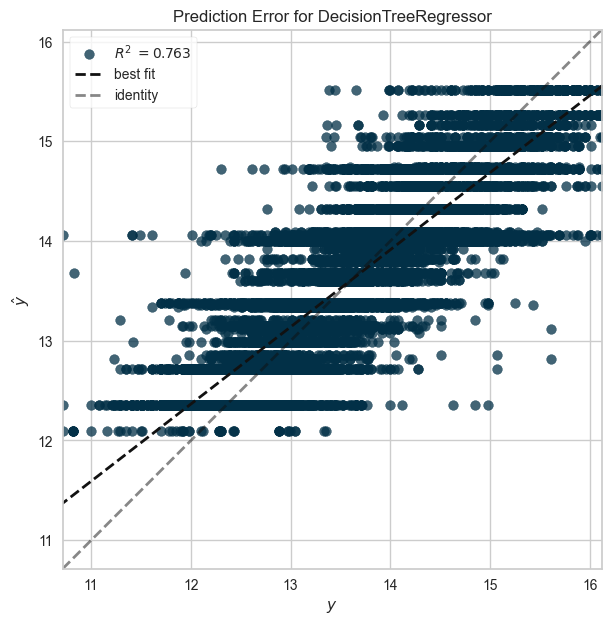

<Axes: title={'center': 'Prediction Error for DecisionTreeRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [52]:
# exibe gráfico
fig, ax = plt.subplots(figsize=(7,7))
pev = PredictionError(model_dt)
pev.fit(X_train, y_train)
pev.score(X_test, y_test)
pev.poof()

In [53]:
r2_dtr = r2_score(y_test, y_pred)
r2_dtr

0.7632699300960208

In [54]:
mse_dtr = mean_squared_error(y_test,y_pred)
mse_dtr

0.1925983135983235

___

**Método Ensamble**

É um método que combina as diferentes predições de multiplos modelos com foco em ter uma performance melhor.

### Floresta Aleatória (Regressão)

A floresta aleatória calcula a média dos resultados de várias árvores de decisão não correlacionadas.

**Vantagens:**
- Redução de ocorrência de overfitting
- Flexibilidade
- Lida com dados faltantes
- Boa acurácia
- Grandes volumes de dados

**Desvantagens:**
- Modelo complexo
- Demanda mais poder computacional

In [55]:
rf = RandomForestRegressor(random_state=42, n_estimators=10, max_depth=5)

In [56]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=5, n_estimators=10, random_state=42)

In [57]:
y_pred = rf.predict(X_test)

**Gráfico de erro de predição**

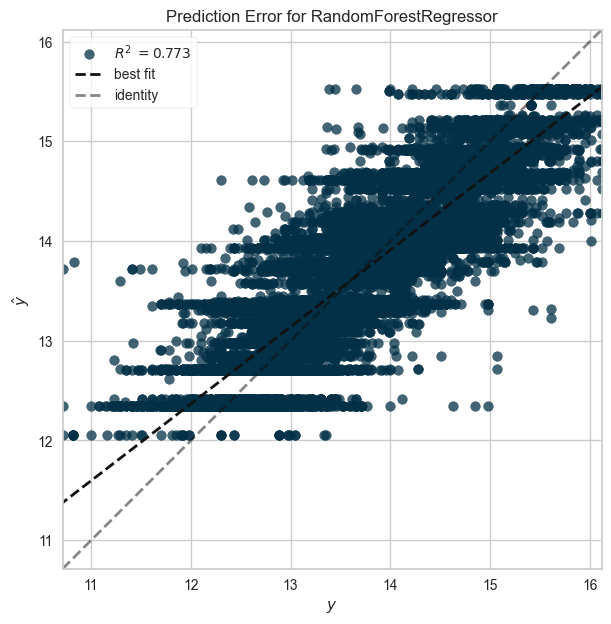

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [58]:
# exibe o gráfico
fig, ax = plt.subplots(figsize=(7,7))
pev = PredictionError(rf)
pev.fit(X_train, y_train)
pev.score(X_test, y_test)
pev.poof()

In [59]:
r2_rf = r2_score(y_test, y_pred)
r2_rf

0.77272733472071

In [60]:
mse = mean_squared_error(y_test,y_pred)
mse

0.18490397978398837

### Melhorando desempenho do modelo com Validação Cruzada

**Otimizando Árvore de Decisão**

In [61]:
cv = KFold(n_splits=5, shuffle=True)

In [62]:
desempenho_cross_val_r2 = cross_val_score(
    estimator=model_dt,
    X = X_train,
    y = y_train,
    scoring='r2',
    cv = cv
)

In [63]:
print('Desempenho médio de R²: {}'.format(round(desempenho_cross_val_r2.mean(),3)))

Desempenho médio de R²: 0.767


**Random Search Validação**

In [64]:
# selecionando hiperparâmetros
param_grid_dt = {
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [6,8,10,12,14,16],
    'min_samples_leaf': [6,8,10],
    'min_samples_split': [8,10,12,14,16],
    'max_features': ['sqrt','log2','auto']
}

In [66]:
# instanciando cv
random_csv_dt = RandomizedSearchCV(
    model_dt,        # atribui o modelo
    param_grid_dt,   # utiliza os parâmtros pré-selecionados
    n_iter=5,        # número de iteração
    cv=cv,           # validação cruzada
    scoring='r2',    # métrica de desempenho
    n_jobs=-1        # força a utilização de todos os núcleos para o processamento
)

In [67]:
# ajusta o random searchCV aos dados de treino
randomcv_dtr = random_csv_dt.fit(X_train,y_train)

In [68]:
pd.DataFrame(randomcv_dtr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,21.094577,0.124539,0.003367,0.000522,8,8,log2,14,absolute_error,"{'min_samples_split': 8, 'min_samples_leaf': 8...",0.781428,0.797401,0.788146,0.791777,0.796684,0.791087,0.005893,2
1,0.079004,0.007152,0.006229,0.002146,14,8,log2,16,squared_error,"{'min_samples_split': 14, 'min_samples_leaf': ...",0.793162,0.802320,0.796915,0.795514,0.806427,0.798867,0.004831,1
2,0.008161,0.001316,0.000000,0.000000,10,6,auto,10,squared_error,"{'min_samples_split': 10, 'min_samples_leaf': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,0.007661,0.000484,0.000000,0.000000,12,10,auto,8,squared_error,"{'min_samples_split': 12, 'min_samples_leaf': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,0.008966,0.001310,0.000000,0.000000,10,8,auto,16,absolute_error,"{'min_samples_split': 10, 'min_samples_leaf': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [ ]:
# melhores hiperparâmetros para o modelo
randomcv_dtr.best_params_

{'min_samples_split': 14,
 'min_samples_leaf': 8,
 'max_features': 'log2',
 'max_depth': 16,
 'criterion': 'squared_error'}

In [ ]:
# melhor desempenho do modelo
randomcv_dtr.best_score_

0.798867411397623

In [71]:
# atribuindo modelo otimizado
dtr_otimizado = DecisionTreeRegressor(
    criterion='squared_error',
    max_depth=16,
    min_samples_split=14,
    min_samples_leaf=8,
    max_features='log2'
)

In [72]:
dtr_otimizado.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=16, max_features='log2', min_samples_leaf=8,
                      min_samples_split=14)

In [73]:
dtr_otimizado_pred = dtr_otimizado.predict(X_test)

In [74]:
r2_score(y_test, dtr_otimizado_pred)

0.8005683632777476

- Com o ajuste de hiperparâmetros e a validação cruzada, nosso modelo de árvore de decisão saiu de uma taxa de R² = 76% e alcançou um desempenho de 80%. Uma melhora de 4% no coeficiente de determinação.

____

**Otimizando Floresta Aleatória**

In [76]:
desempenhoRF_cross_val_r2 = cross_val_score(
    estimator=rf,
    X = X_train,
    y = y_train,
    scoring = 'r2',
    cv = cv
)

print('Desempenho médio de R²: {}'.format(round(desempenhoRF_cross_val_r2.mean(),3)))

Desempenho médio de R²: 0.779


**Random Search Validação (Floresta Aleatória)**

In [80]:
# definindo hiperparâmetros
param_random_rf = {
    'n_estimators': [150,200],  # define a quantidade de árvores da floresta
    'max_depth': [20,30],       # profundidade
    'min_samples_split': [8,10], # quantidade mínima por amostra
    'min_samples_leaf': [3]      # quantidade de folhas
}

In [81]:
# instanciando otimizador random searchCV
random_cv_rf = RandomizedSearchCV(
    rf,
    param_random_rf,
    n_iter=5,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

In [82]:
#ajustando modelo otimizado aos dados de treino
rf_randomcv = random_cv_rf.fit(X_train, y_train)

In [83]:
pd.DataFrame(rf_randomcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,36.314572,0.180290,0.444787,0.017781,200,8,3,20,"{'n_estimators': 200, 'min_samples_split': 8, ...",0.835830,0.838002,0.837013,0.836010,0.842336,0.837838,0.002380,2
1,39.165902,1.451575,0.468048,0.022375,200,8,3,30,"{'n_estimators': 200, 'min_samples_split': 8, ...",0.835316,0.837169,0.836173,0.835341,0.841810,0.837162,0.002421,5
2,29.154989,0.744595,0.354349,0.003706,150,8,3,20,"{'n_estimators': 150, 'min_samples_split': 8, ...",0.835617,0.837925,0.836853,0.835935,0.842274,0.837720,0.002414,3
3,35.510208,0.191467,0.333629,0.027792,200,10,3,30,"{'n_estimators': 200, 'min_samples_split': 10,...",0.835933,0.837454,0.836548,0.835577,0.841983,0.837499,0.002330,4
4,25.791198,2.406466,0.267445,0.034786,150,10,3,20,"{'n_estimators': 150, 'min_samples_split': 10,...",0.836088,0.838049,0.837143,0.836019,0.842345,0.837929,0.002331,1


In [84]:
rf_randomcv.best_params_

{'n_estimators': 150,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_depth': 20}

In [85]:
rf_randomcv.best_score_

0.8379285218688322

In [86]:
# definindo modelo com melhores parâmetros
rf_otimizado = RandomForestRegressor(
    n_estimators=150,
    min_samples_split=10,
    min_samples_leaf=3,
    max_depth=20
)

In [ ]:
# treinando modelo
rf_otimizado.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=3, min_samples_split=10,
                      n_estimators=150)

In [90]:
# prevendo com o modelo
rf_orimizado_pred = rf_otimizado.predict(X_test)

In [91]:
# R²
r2_score(y_test, rf_orimizado_pred)

0.8384192364936904

- Nosso modelo obteve um ganho aproximadamente de 6% em relação ao primeiro modelo, saindo de 78% - 84% de R²

Dado os modelos otimizados, percebemos que o modelo que possuiu o melhor desempenho foi o de Floresta Aleatória com RandomSearch, e será ele que escolheremos.

___

**Criando um caso fictíceo para a utilização do modelo**

Um cliente nos passou as informações do seu imóvel, e nos pediu para informar o valor aproximado do quanto custaria, baseado nos valores dos imóveis na região.

As informações dadas por ele está armazenada no DataFrame abaixo.

In [103]:
# informação do imóvel do cliente
imovel_cliente = pd.DataFrame(
    {
        'tax_iptu':[4.6],
        'tax_condo':[5.45],
        'bedrooms':[2], 
        'bathrooms':[1],
        'suites':[1],
        'parkingSpaces':[1],
        'usableAreas':[4],
        'totalAreas':[4.68],
        'floors':[0],
        'unitsOnTheFloor':[0],
        'unitFloor':[0],
        'unit_Apartamento':[0],
        'unit_Casa':[1],
        'unit_Outros':[0],
        'zone_Zona Central':[0],
        'zone_Zona Norte':[0],
        'zone_Zona Oeste':[1],
        'zone_Zona Sul':[0]
    }
)

In [104]:
imovel_cliente

,tax_iptu,tax_condo,bedrooms,bathrooms,suites,parkingSpaces,usableAreas,totalAreas,floors,unitsOnTheFloor,unitFloor,unit_Apartamento,unit_Casa,unit_Outros,zone_Zona Central,zone_Zona Norte,zone_Zona Oeste,zone_Zona Sul
0,4.6,5.45,2,1,1,1,4,4.68,0,0,0,0,1,0,0,0,1,0


In [105]:
# passando os dados do cliente no modelo selecionado
predicao_cliente = rf_otimizado.predict(imovel_cliente)

In [106]:
np.expm1(predicao_cliente)

array([378550.60493286])

- Lembrando que o resultado do modelo sairia transoformado pois anteriormente utilizamos o Loarítmo para escalonar os dados. Como nosso objetivo é mostrar o valor real, precisamos transforma-lo para a escala normal, por conta disso utilizamos o `np.expm1`.

- O preço estimado do imóvel do cliente é: R$ 378.550,60